In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer
)
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from scipy.stats import loguniform, randint

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
CSV_PATH = Path("../data/bank-additional-full.csv")
TARGET_COL = "y"

In [2]:
# 1) Carregar
df = pd.read_csv(CSV_PATH, sep=";")
print("Shape:", df.shape)
print(df.head())

# 2) Target
if TARGET_COL not in df.columns:
    raise ValueError("Coluna alvo 'y' não encontrada.")

X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].map({"no": 0, "yes": 1}).astype(int)

# 3) Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

Shape: (41188, 21)
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  eur

In [3]:
# 4) Preprocessamento
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])


=== Baseline (most_frequent) ===
Accuracy : 0.8873512988589464
Precision: 0.0
Recall   : 0.0
F1       : 0.0


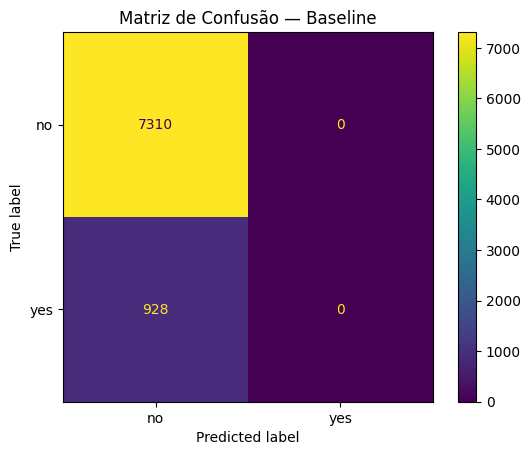

In [4]:
# 5) Baseline (essencial)
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

print("\n=== Baseline (most_frequent) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_base))
print("Precision:", precision_score(y_test, y_pred_base, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_base, zero_division=0))
print("F1       :", f1_score(y_test, y_pred_base, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, display_labels=["no", "yes"], values_format="d")
plt.title("Matriz de Confusão — Baseline")
plt.show()

In [5]:
# 6) Modelos (>=5)
pipelines = {
    "LogReg": Pipeline([("preprocess", preprocess),
                        ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),

    "KNN": Pipeline([("preprocess", preprocess),
                     ("model", KNeighborsClassifier())]),

    "DecisionTree": Pipeline([("preprocess", preprocess),
                              ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))]),

    "RandomForest": Pipeline([("preprocess", preprocess),
                              ("model", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))]),

    "HistGB": Pipeline([("preprocess", preprocess),
                        ("model", HistGradientBoostingClassifier(random_state=RANDOM_STATE))]),
}

# 7) CV + scoring
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
}

# 8) Espaços de busca (enxutos)
param_dists = {
    "LogReg": {
        "model__C": loguniform(1e-2, 1e2),
        "model__class_weight": [None, "balanced"],
    },
    "KNN": {
        "model__n_neighbors": randint(3, 80),
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    },
    "DecisionTree": {
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_leaf": randint(1, 30),
        "model__class_weight": [None, "balanced"],
    },
    "RandomForest": {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_leaf": randint(1, 20),
        "model__class_weight": [None, "balanced"],
        "model__max_features": ["sqrt", 0.5],
    },
    "HistGB": {
        "model__learning_rate": loguniform(1e-2, 2e-1),
        "model__max_depth": [None, 5, 10],
        "model__max_iter": [200, 400],
    },
}

In [6]:
# 9) Busca + avaliação no teste
results = []
best_estimators = {}

N_ITER = 15

for name, pipe in pipelines.items():
    print(f"\n=== RandomizedSearch: {name} ===")

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dists[name],
        n_iter=N_ITER,
        scoring=scoring,
        refit="f1",
        cv=cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0,
        error_score="raise",
    )

    t0 = time()
    search.fit(X_train, y_train)
    elapsed = time() - t0

    best_estimators[name] = search.best_estimator_
    y_pred = search.best_estimator_.predict(X_test)

    results.append({
        "model": name,
        "cv_f1": search.best_score_,
        "test_f1": f1_score(y_test, y_pred, zero_division=0),
        "test_precision": precision_score(y_test, y_pred, zero_division=0),
        "test_recall": recall_score(y_test, y_pred, zero_division=0),
        "test_accuracy": accuracy_score(y_test, y_pred),
        "best_params": search.best_params_,
        "time_s": round(elapsed, 1),
    })

results_df = pd.DataFrame(results).sort_values("test_f1", ascending=False)
print("\nResumo:")
print(results_df[["model", "cv_f1", "test_f1", "test_precision", "test_recall", "test_accuracy", "time_s"]])



=== RandomizedSearch: LogReg ===



=== RandomizedSearch: KNN ===

=== RandomizedSearch: DecisionTree ===

=== RandomizedSearch: RandomForest ===

=== RandomizedSearch: HistGB ===

Resumo:
          model     cv_f1   test_f1  test_precision  test_recall  \
3  RandomForest  0.638762  0.665850        0.536184     0.878233   
4        HistGB  0.591743  0.621382        0.687582     0.566810   
0        LogReg  0.583937  0.602925        0.450667     0.910560   
2  DecisionTree  0.582838  0.595170        0.443856     0.903017   
1           KNN  0.457575  0.492978        0.707661     0.378233   

   test_accuracy  time_s  
3       0.900704   338.2  
4       0.922190    73.4  
0       0.864894    11.6  
2       0.861617     8.4  
1       0.912357   234.3  



=== Melhor modelo (hold-out) ===
Modelo: RandomForest
Best params: {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__max_features': 0.5, 'model__min_samples_leaf': 7, 'model__n_estimators': 400}
              precision    recall  f1-score   support

          no       0.98      0.90      0.94      7310
         yes       0.54      0.88      0.67       928

    accuracy                           0.90      8238
   macro avg       0.76      0.89      0.80      8238
weighted avg       0.93      0.90      0.91      8238



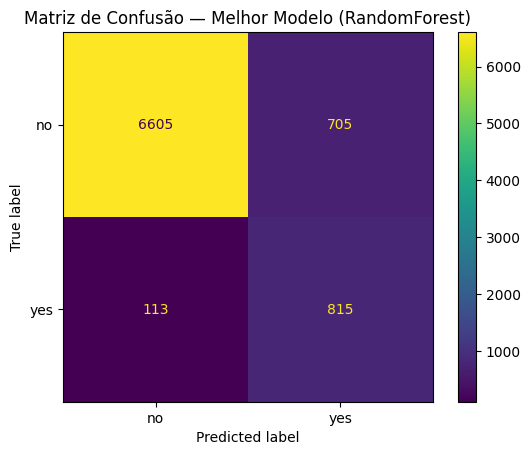

In [7]:
# 10) Vencedor
best_name = results_df.iloc[0]["model"]
best_model = best_estimators[best_name]

y_pred_best = best_model.predict(X_test)
print("\n=== Melhor modelo (hold-out) ===")
print("Modelo:", best_name)
print("Best params:", results_df.iloc[0]["best_params"])
print(classification_report(y_test, y_pred_best, target_names=["no", "yes"], zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, display_labels=["no", "yes"], values_format="d")
plt.title(f"Matriz de Confusão — Melhor Modelo ({best_name})")
plt.show()